## Data Visualisation

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [8]:
def get_data():
    df = pd.read_excel('Football_Players.xls').reset_index(drop=True)
    df = df.set_index('Year').T

    target_col = ['World rating']
    cols = []
    for i in range(2, len(df.columns) - 1):
        ij = df.columns[i]
        if (str(ij) == 'nan'):
            continue
        if df[ij][2016] != None:
            cols.append(df.columns[i])
    X, y = df[cols].values, df[target_col].values
    return X, y.flatten()

Football Player List

In [133]:
X, y = get_data()

X_learn = X[:70]
y_learn = y[:70]

X_test = X[70:]
y_test = y[70:]

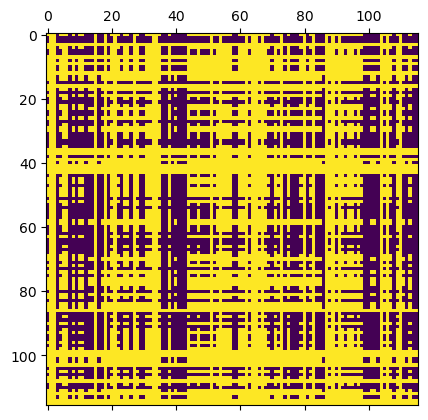

In [77]:
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (y[i] >= y[j]):
            image[i, j] = 1
        else:
            image[i, j] = 0
plt.matshow(image)

plt.show()

Students Marks List

In [52]:
def get_data():
    df = pd.read_excel('Student_Marks.xls').reset_index(drop=True)
    df = df.set_index('Year').T

    target_col = ['Final exam']
    cols = []
    for i in range(2, len(df.columns) - 1):
        ij = df.columns[i]
        if (str(ij) == 'nan'):
            continue
        else:
        #if df[ij][2016] != None:
            cols.append(df.columns[i])
    X, y = df[cols].values, df[target_col].values
    return X, y.flatten()

In [54]:
X, y = get_data()

X_learn = X[:70]
y_learn = y[:70]

X_test = X[70:]
y_test = y[70:]

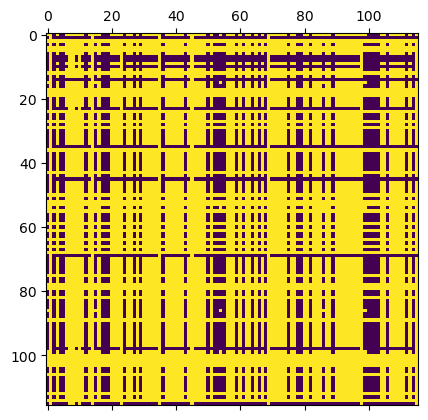

In [56]:
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (y[i] >= y[j]):
            image[i, j] = 1
        else:
            image[i, j] = 0
plt.matshow(image)

plt.show()

Red List

In [46]:
def get_data():
    df = pd.read_excel('Red_Lists.xls').reset_index(drop=True)
    df = df.set_index('Year').T

    target_col = ['RDBRFCategoryID']
    cols = []
    for i in range(2, len(df.columns) - 1):
        ij = df.columns[i]
        if (str(ij) == 'nan'):
            continue
        else:
        #if df[ij][2016] != None:
            cols.append(df.columns[i])
    X, y = df[cols].values, df[target_col].values
    return X, y.flatten()

In [48]:
X, y = get_data()

X_learn = X[:70]
y_learn = y[:70]

X_test = X[70:]
y_test = y[70:]

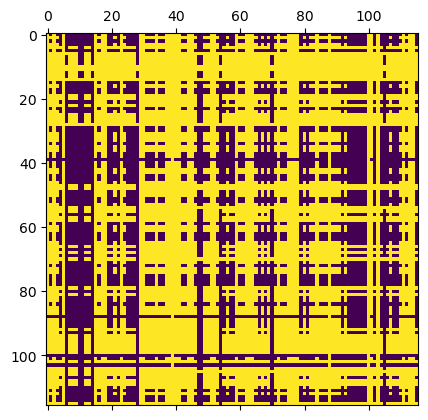

In [50]:
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (y[i] >= y[j]):
            image[i, j] = 1
        else:
            image[i, j] = 0
plt.matshow(image)

plt.show()

## Partial Orders

In [27]:
def glm_fit(X, target):
    model = sm.GLM(target, X, family=sm.families.Binomial())
    result = model.fit(method_kwargs={'warn_convergence': False})
    return result

def learnPartialOrders(X, y):
    labels = np.unique(y)
    num_rows, num_cols = X.shape[0], X.shape[1]
    partialOrderMat = np.zeros([num_rows ** 2, num_cols])
    
    for i in range(num_cols):
        curVec = X[:, i]
        firstMat = np.tile(curVec[:, np.newaxis], (1, len(curVec)))
        secondMat = np.tile(curVec[np.newaxis, :], (len(curVec), 1))
        current_mat = np.greater_equal(firstMat, secondMat).astype(float)
        
        zero_idx = np.where(curVec == 0)[0]
        current_mat[zero_idx, :] = 0
        current_mat[:, zero_idx] = 0
        
        partialOrderMat[:, i] = current_mat.flatten()

    firstMat = np.tile(y[:, np.newaxis], (1, len(y)))
    secondMat = np.tile(y[np.newaxis, :], (len(y), 1))
    yMat = np.greater_equal(firstMat, secondMat).astype(float)
    y_vec = np.reshape(yMat, [yMat.shape[0] ** 2, 1])
    
    model = sm.GLM(y_vec, partialOrderMat, family=sm.families.Binomial())
    result = model.fit()
    w0 = result.params

    y_est = result.predict(partialOrderMat)
    y_mat_est = np.reshape(y_est, [len(y), len(y)])
    
    y_mat_est_conv = np.zeros((y_mat_est.shape[0], len(labels)))
    for class_idx in range(len(labels)):
        y_mat_est_conv[:, class_idx] = np.sum(y_mat_est[:, y == labels[class_idx]], axis=1)
    
    par_w = np.zeros([y_mat_est_conv.shape[1], len(labels) - 1])
    for class_idx in range(len(labels) - 1):
        y_curr = (y > labels[class_idx]).astype(float)
        par_w[:, class_idx] = glm_fit(y_mat_est_conv, y_curr).params

    y_est = testPartialOrders(X, y, X, w0, par_w, labels)
    return w0, par_w, y_est

In [23]:
def testPartialOrders(X_learn, y_learn, X_test, w0, par_w, labels = np.array([1, 2, 3, 4, 5])):

    y_fit = np.zeros((X_test.shape[0], len(labels) - 1))
    y_est = np.ones(X_test.shape[0])

    for idx_test in range(X_test.shape[0]):
        x_test_obj = X_test[idx_test]
        x_test_obj_mat = np.tile(x_test_obj, (X_learn.shape[0], 1))
        
        # Создание матрицы частичного порядка
        partial_order_mat = (x_test_obj_mat >= X_learn).astype(float)
        partial_order_mat[X_learn == 0] = 0
        #partial_order_mat[x_test_obj_mat == 0] = 0
        
        # Прогнозирование с помощью glmval
        y_est0 = sm.families.Binomial().link.inverse(w0.dot(partial_order_mat.T))
        
        y_vec_conv = np.zeros(len(labels))
        
        for cl_idx in range(len(labels)):
            y_vec_conv[cl_idx] = np.sum(y_est0[y_learn == labels[cl_idx]])
        
        for cl_idx in range(len(labels) - 1):
            y_fit[idx_test, cl_idx] = sm.families.Binomial().link.inverse(par_w[:, cl_idx].dot(y_vec_conv))
    
    # Преобразование y_fit
    y_fit = np.column_stack((1 - y_fit[:, 0], 
                              y_fit[:, 1:] - np.roll(y_fit[:, 1:], shift=1, axis=1),
                              y_fit[:, -1]))
    
    y_est = np.argmax(y_fit, axis=1)
    return y_est + 1

Football Player List

In [81]:
X, y = get_data()

X_learn = X[:70]
y_learn = y[:70]

X_test = X[70:]
y_test = y[70:]

w0, w, res = learnPartialOrders(X_learn, y_learn)
mae_val = np.mean(np.abs(y_learn - res))

res = testPartialOrders(X_learn, y_learn, X_test, w0, w)
mae_test = np.mean(np.abs(y_test - res))

print('Validation MAE:', mae_val)
print('Test MAE      :', mae_test)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Validation MAE: 1.1428571428571428
Test MAE      : 1.6956521739130435


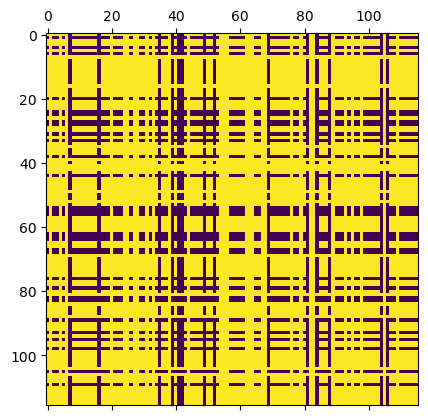

In [83]:
res = testPartialOrders(X_learn, y_learn, X, w0, w)
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (res[i] >= res[j]):
            image[i, j] = 1
        else:
            image[i, j] = 0
plt.matshow(image)

plt.show()

Student Mark List

In [58]:
X, y = get_data()

X_learn = X[:70]
y_learn = y[:70]

X_test = X[70:]
y_test = y[70:]

w0, w, res = learnPartialOrders(X_learn, y_learn)
mae_val = np.mean(np.abs(y_learn - res))

res = testPartialOrders(X_learn, y_learn, X_test, w0, w)
mae_test = np.mean(np.abs(y_test - res))

print('Validation MAE:', mae_val)
print('Test MAE      :', mae_test)

Validation MAE: 1.2142857142857142
Test MAE      : 1.5217391304347827


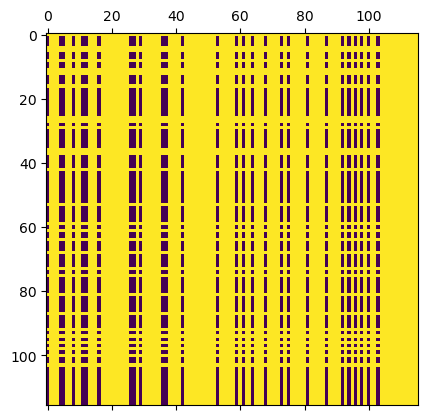

In [60]:
res = testPartialOrders(X_learn, y_learn, X, w0, w)
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (res[i] >= res[j]):
            image[i, j] = 1
        else:
            image[i, j] = 0
plt.matshow(image)

plt.show()

Red List

In [29]:
X, y = get_data()

X_learn = X[:70]
y_learn = y[:70]

X_test = X[70:]
y_test = y[70:]

w0, w, res = learnPartialOrders(X_learn, y_learn)
mae_val = np.mean(np.abs(y_learn - res))

res = testPartialOrders(X_learn, y_learn, X_test, w0, w, labels = np.array([0, 1, 2, 3, 4, 5, 6]))
mae_test = np.mean(np.abs(y_test - res))

print('Validation MAE:', mae_val)
print('Test MAE      :', mae_test)

C:\Users\User\AppData\Local\Temp\ipykernel_12356\326102444.py:15: RuntimeWarning: invalid value encountered in greater_equal
  current_mat = np.greater_equal(firstMat, secondMat).astype(float)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\User\AppData\Local\Temp\ipykernel_12356\33

Validation MAE: 0.9285714285714286
Test MAE      : 0.8695652173913043


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


C:\Users\User\AppData\Local\Temp\ipykernel_12356\3302977016.py:11: RuntimeWarning: invalid value encountered in greater_equal
  partial_order_mat = (x_test_obj_mat >= X_learn).astype(float)


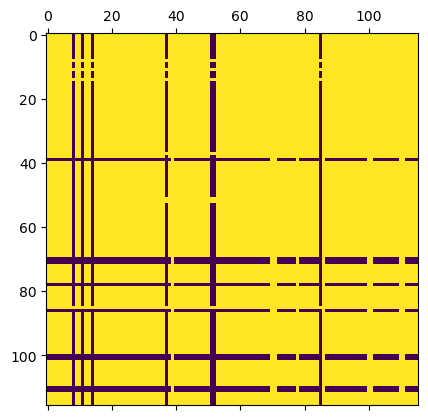

In [33]:
res = testPartialOrders(X_learn, y_learn, X, w0, w, labels = np.array([0, 1, 2, 3, 4, 5, 6]))
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (res[i] >= res[j]):
            image[i, j] = 1
        else:
            image[i, j] = 0
plt.matshow(image)

plt.show()

## Isotonic regression

In [35]:
from sklearn.isotonic import IsotonicRegression

Football Player List

In [85]:
clf = IsotonicRegression(y_min=1.0, y_max=5.0, out_of_bounds='clip')
y_learn = y_learn.astype('int')
clf.fit(np.mean(X_learn, axis=1), y_learn)

res = clf.predict(np.mean(X_learn, axis=1)).astype('int')
mae_val = np.mean(np.abs(y_learn - res))

res = clf.predict(np.mean(X_test, axis=1)).astype('int')
mae_test = np.mean(np.abs(y_test - res)) 

print('Validation MAE:', mae_val)
print('Test MAE      :', mae_test)

Validation MAE: 0.9857142857142858
Test MAE      : 1.2826086956521738


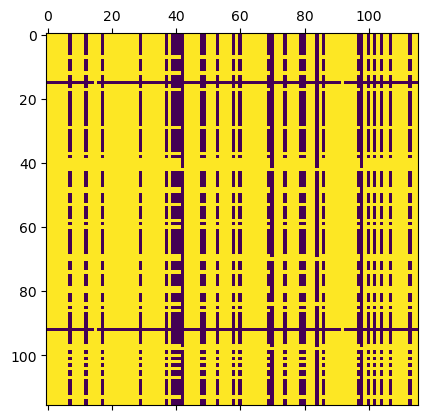

In [86]:
res = clf.predict(np.mean(X, axis=1)).astype('int')
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (res[i] >= res[j]):
            image[i, j] = 1
        else:
            image[i, j] = 0
plt.matshow(image)

plt.show()

Student Marks List

In [66]:
clf = IsotonicRegression(y_min=1.0, y_max=5.0, out_of_bounds='clip')
y_learn = y_learn.astype('int')
clf.fit(np.mean(X_learn, axis=1), y_learn)

res = clf.predict(np.mean(X_learn, axis=1)).astype('int')
mae_val = np.mean(np.abs(y_learn - res))

res = clf.predict(np.mean(X_test, axis=1)).astype('int')
mae_test = np.mean(np.abs(y_test - res)) 

print('Validation MAE:', mae_val)
print('Test MAE      :', mae_test)

Validation MAE: 0.8142857142857143
Test MAE      : 0.6956521739130435


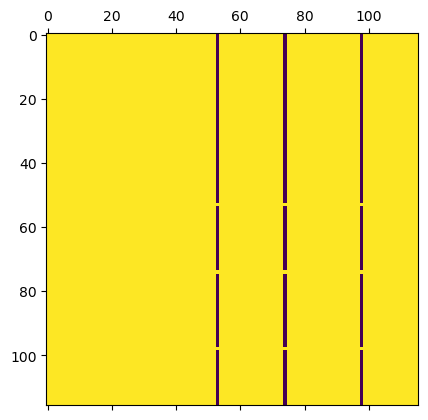

In [68]:
res = clf.predict(np.mean(X, axis=1)).astype('int')
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (res[i] >= res[j]):
            image[i, j] = 1
        else:
            image[i, j] = 0
plt.matshow(image)

plt.show()

Red List

In [64]:
X_learn[9][-2] = 0

In [66]:
clf = IsotonicRegression(y_min=1.0, y_max=5.0, out_of_bounds='clip')
y_learn = y_learn.astype('int')
clf.fit(np.mean(X_learn, axis=1), y_learn)

res = clf.predict(np.mean(X_learn, axis=1)).astype('int')
mae_val = np.mean(np.abs(y_learn - res))

res = clf.predict(np.mean(X_test, axis=1)).astype('int')
mae_test = np.mean(np.abs(y_test - res)) 

print('Validation MAE:', mae_val)
print('Test MAE      :', mae_test)

Validation MAE: 0.9428571428571428
Test MAE      : 0.7608695652173914


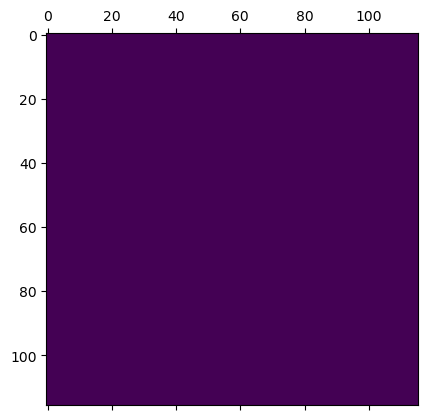

In [68]:
res = clf.predict(np.mean(X, axis=1)).astype('int')
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (res[i] >= res[j]):
            image[i, j] = 1
        else:
            image[i, j] = 0
plt.matshow(image)

plt.show()

## Oblique decision trees

In [70]:
from scikit_obliquetree.HHCART import HouseHolderCART
from scikit_obliquetree.segmentor import MSE, MeanSegmentor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score

Football Player List

In [88]:
clf = BaggingRegressor(
   HouseHolderCART(MSE(), MeanSegmentor(), max_depth=3),
   n_estimators=100,
    n_jobs=-1,
)
y_learn = y_learn.astype('int')
X_learn = X_learn.astype('int')
clf.fit(X_learn, y_learn)

res = clf.predict(X_learn).astype('int')
mae_val = np.mean(np.abs(y_learn - res))

res = clf.predict(X_test).astype('int')
mae_test = np.mean(np.abs(y_test - res)) 

print('Validation MAE:', mae_val)
print('Test MAE      :', mae_test)

Validation MAE: 0.4714285714285714
Test MAE      : 1.1521739130434783


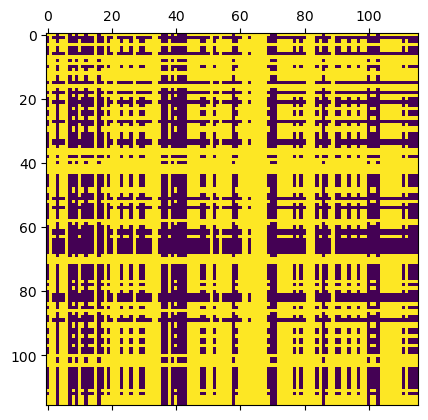

In [89]:
res = clf.predict(X).astype('int')
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (res[i] >= res[j]):
            image[i, j] = 1
        else:
            image[i, j] = 0
plt.matshow(image)

plt.show()

Student Marks List

In [84]:
clf = BaggingRegressor(
   HouseHolderCART(MSE(), MeanSegmentor(), max_depth=3),
   n_estimators=100,
    n_jobs=-1,
)
y_learn = y_learn.astype('int')
X_learn = X_learn.astype('int')
clf.fit(X_learn, y_learn)

res = clf.predict(X_learn).astype('int')
mae_val = np.mean(np.abs(y_learn - res))

res = clf.predict(X_test).astype('int')
mae_test = np.mean(np.abs(y_test - res)) 

print('Validation MAE:', mae_val)
print('Test MAE      :', mae_test)

Validation MAE: 0.45714285714285713
Test MAE      : 0.6521739130434783


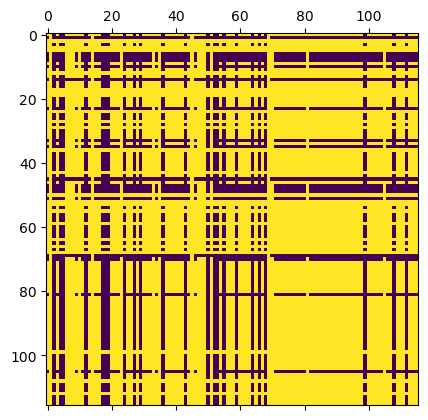

In [86]:
res = clf.predict(X).astype('int')
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (res[i] >= res[j]):
            image[i, j] = 1
        else:
            image[i, j] = 0
plt.matshow(image)

plt.show()

Red List

In [73]:
clf = BaggingRegressor(
   HouseHolderCART(MSE(), MeanSegmentor(), max_depth=3),
   n_estimators=100,
    n_jobs=-1,
)
y_learn = y_learn.astype('int')
X_learn = X_learn.astype('int')
clf.fit(X_learn, y_learn)

res = clf.predict(X_learn).astype('int')
mae_val = np.mean(np.abs(y_learn - res))

res = clf.predict(X_test).astype('int')
mae_test = np.mean(np.abs(y_test - res)) 

print('Validation MAE:', mae_val)
print('Test MAE      :', mae_test)

Validation MAE: 0.5142857142857142
Test MAE      : 0.782608695652174


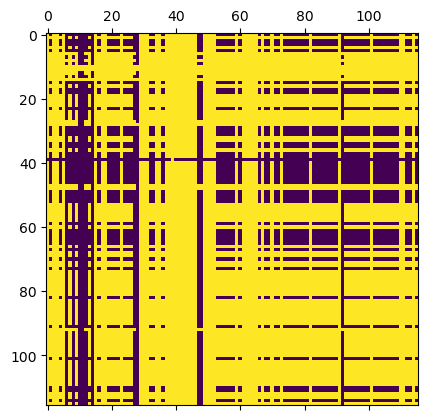

In [75]:
res = clf.predict(X).astype('int')
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (res[i] >= res[j]):
            image[i, j] = 1
        else:
            image[i, j] = 0
plt.matshow(image)

plt.show()

## Stochastic Partial Orders

In [77]:
def glm_fit(X, target):
    model = sm.GLM(target, X, family=sm.families.Binomial())
    result = model.fit(method_kwargs={'warn_convergence': False})
    return result

def learnPartialOrders(X, y):
    labels = np.unique(y)
    num_rows, num_cols = X.shape[0], X.shape[1]
    partialOrderMat = np.zeros([num_rows ** 2, num_cols])
    
    for i in range(num_cols):
        curVec = X[:, i]
        firstMat = np.tile(curVec[:, np.newaxis], (1, len(curVec)))
        secondMat = np.tile(curVec[np.newaxis, :], (len(curVec), 1))
        current_mat = np.greater_equal(firstMat, secondMat).astype(float)
        
        zero_idx = np.where(curVec == 0)[0]
        current_mat[zero_idx, :] = 0
        current_mat[:, zero_idx] = 0
        
        partialOrderMat[:, i] = current_mat.flatten()

    firstMat = np.tile(y[:, np.newaxis], (1, len(y)))
    secondMat = np.tile(y[np.newaxis, :], (len(y), 1))
    yMat = np.greater_equal(firstMat, secondMat).astype(float)
    y_vec = np.reshape(yMat, [yMat.shape[0] ** 2, 1])
    
    model = sm.GLM(y_vec, partialOrderMat, family=sm.families.Binomial())
    result = model.fit()
    w0 = result.params

    y_est = result.predict(partialOrderMat)
    y_mat_est = np.reshape(y_est, [len(y), len(y)])
    plt.matshow(yMat)

    plt.show()
    
    y_mat_est_conv = np.zeros((y_mat_est.shape[0], len(labels)))
    for class_idx in range(len(labels)):
        y_mat_est_conv[:, class_idx] = np.sum(y_mat_est[:, y == labels[class_idx]], axis=1)

    
    par_w = np.zeros([y_mat_est_conv.shape[1], len(labels) - 1])
    for class_idx in range(len(labels) - 1):
        y_curr = (y > labels[class_idx]).astype(float)
        par_w[:, class_idx] = glm_fit(y_mat_est_conv, y_curr).params
        

    y_est = testPartialOrders(X, y, X, w0, par_w)
    return w0, par_w, y_est

Football Player List

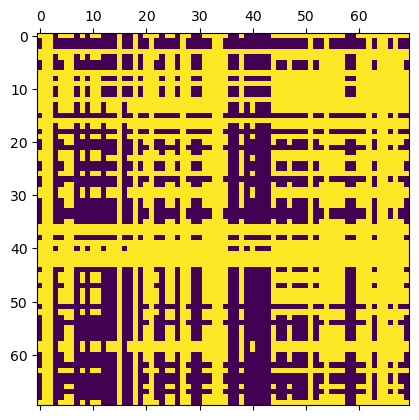

In [122]:
w0, w, res = learnPartialOrders(X_learn, y_learn)

In [120]:
res

array([2, 1, 2, 2, 1, 2, 1, 5, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 1, 2,
       2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 5, 2, 2, 1, 5, 2, 5, 5, 2,
       1, 2, 2, 2, 2, 5, 2, 2, 5, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2,
       2, 1, 1, 5], dtype=int64)

In [ ]:
def testPartialOrders(X_learn, y_learn, X_test, w0, par_w):
    labels = np.array([1, 2, 3, 4, 5])

    y_fit = np.zeros((X_test.shape[0], len(labels) - 1))
    y_est = np.ones(X_test.shape[0])

    for idx_test in range(X_test.shape[0]):
        x_test_obj = X_test[idx_test]
        x_test_obj_mat = np.tile(x_test_obj, (X_learn.shape[0], 1))
        
        # Создание матрицы частичного порядка
        partial_order_mat = (x_test_obj_mat >= X_learn).astype(float)
        partial_order_mat[X_learn == 0] = 0
        #partial_order_mat[x_test_obj_mat == 0] = 0
        
        # Прогнозирование с помощью glmval
        y_est0 = sm.families.Binomial().link.inverse(w0.dot(partial_order_mat.T))
        
        y_vec_conv = np.zeros(len(labels))
        
        for cl_idx in range(len(labels)):
            y_vec_conv[cl_idx] = np.sum(y_est0[y_learn == labels[cl_idx]])
        
        for cl_idx in range(len(labels) - 1):
            y_fit[idx_test, cl_idx] = sm.families.Binomial().link.inverse(par_w[:, cl_idx].dot(y_vec_conv))
    
    # Преобразование y_fit
    y_fit = np.column_stack((1 - y_fit[:, 0], 
                              y_fit[:, 1:] - np.roll(y_fit[:, 1:], shift=1, axis=1),
                              y_fit[:, -1]))
    
    y_est = np.argmax(y_fit, axis=1)
    return y_est + 1

In [110]:
def learnStochOrders(X, y):
    X_hat = []
    #X = X.transpose()
    m, n = X.shape[0], X.shape[1]

    for i in range(n):
        X_i = np.array([[X[j, k] - X[i, k] for k in range(n)] for j in range(n)])
        X_hat.append(X_i)
        
    y_hat = []
    for i in range(n):
        y_i = np.array([y[j] - y[i] for j in range(n)])
        y_hat.append(y_i)
    A = np.eye(n)
    for i in range(1, n - 1):
        for j in range(i + 1, n):
            chisl = 0
            znam = 0
            for k1 in range(m):
                for k2 in range(m):
                    if (X[k2, i] >= X[k2, j]):
                        znam += 1
                        if (y[k1] >= y[k2]):
                            chisl += 1
            if (znam == 0):
                p = chisl
            else:
                p = chisl / (m * znam)
            A[i, j] = 2 * p - 1
            A[j, i] = - A[i, j]
    X_all = X_hat[0]
    y_all = y_hat[0]
    for i in range(1, n):
        X_all += X_hat[i]
        y_all += y_hat[i]

    AX = np.linalg.inv((A @ X_all).transpose() @ A @ X_all + np.eye(n))
    w = AX @ (A @ X_all).transpose() @ y_all
    RES = np.eye(m)
    for i in range(m):
        for j in range(m):
            RES[i, j] = y[j] - np.dot(A @ (X[j, :] - X[i, :]), w)
    lamb = np.linalg.inv(RES.transpose() @ RES) @ RES.transpose() @ y
    return A, w, lamb

In [124]:
A, w, lamb = learnStochOrders(X_learn,y_learn)

In [116]:
def getStochOrdersRes(etalons, etalons_y, X, A, w, lamb):
    y = np.array([])
    m, n = X.shape[0], X.shape[1]
    for i in range(m):
        res = 0
        for j in range(len(etalons)):
            res += (etalons_y[j] - np.dot(A @ (etalons[j] - X[i, :]), w)) * lamb[j]
        y = np.append(y, res)
    y_mx = np.max(y)
    y_mn = np.min(y)
    y = (y - y_mn) / (y_mx - y_mn)
    return y + 1

In [93]:
res = getStochOrdersRes(X_learn, y_learn, X_learn, A, w, lamb)
mae_val = np.mean(np.abs(y_learn - res))

res = getStochOrdersRes(X_learn, y_learn, X_test, A, w, lamb)
mae_test = np.mean(np.abs(y_test - res)) 

print('Validation MAE:', mae_val)
print('Test MAE      :', mae_test)

Validation MAE: 1.8142857142857143
Test MAE      : 1.9130434782608696


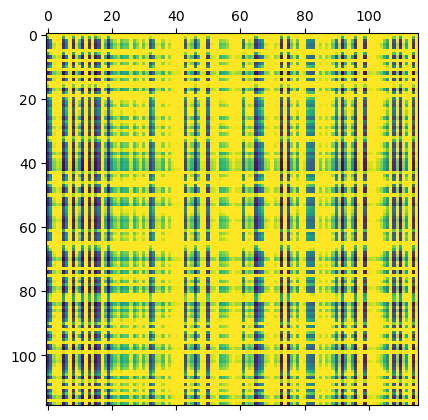

In [129]:
res = getStochOrdersRes(X_learn, y_learn, X, A, w, lamb)
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (res[i] >= res[j]):
            image[i, j] = 1
        else:
            image[i, j] = res[i] / res[j]
        #if (res[i] >= res[j]):
        #    image[i, j] = 1
        #else:
        #    image[i, j] = 0
plt.matshow(image)

plt.show()

In [60]:
res = getStochOrdersRes(X_learn, y_learn, X_learn, A, w, lamb)
mae_val = np.mean(np.abs(y_learn - res))

res = getStochOrdersRes(X_learn, y_learn, X_test, A, w, lamb)
mae_test = np.mean(np.abs(y_test - res)) 

print('Validation MAE:', mae_val)
print('Test MAE      :', mae_test)

Validation MAE: 1.8
Test MAE      : 1.7173913043478262


In [82]:
def learnStochOrders(X, y):
    X_hat = []
    #X = X.transpose()
    n,m = X.shape[0], X.shape[1]
    print(n,m)

    for i in range(n):
        X_i = np.array([[X[j, min(m-1,k)] - X[i, min(m-1,k)] for k in range(n)] for j in range(n)])
        X_hat.append(X_i)
        
    y_hat = []
    for i in range(n):
        y_i = np.array([y[j] - y[i] for j in range(n)])
        y_hat.append(y_i)
    A = np.eye(n)
    for i in range(1, n - 1):
        for j in range(i + 1, n):
            chisl = 0
            znam = 0
            for k1 in range(m):
                for k2 in range(m):
                    if (X[i, k2] >= X[j, k2]):
                        znam += 1
                        if (y[k1] >= y[k2]):
                            chisl += 1
            p = chisl / (m * znam)
            A[i, j] = 2 * p - 1
            A[j, i] = - A[i, j]
    X_all = X_hat[0]
    y_all = y_hat[0]
    for i in range(1, m):
        X_all += X_hat[i]
        y_all += y_hat[i]

    AX = np.linalg.inv(A @ X_all + np.eye(n))
    w = n * AX @ AX.transpose() @ (A @ X_all).transpose() @ y_all
    return A, w

In [29]:
len(X[0,:])

60

In [99]:
A, w = learnStochOrders(X_learn,y_learn)

70 60


In [102]:
print(A.shape,w.shape)

(70, 70) (70,)


In [60]:
X_learn.shape

(70, 60)

In [61]:
y_learn.shape

(70,)

In [100]:
def getStochOrdersRes(X, A, w):
    y = np.array([])
    n, m = X.shape[0], X.shape[1]
    for i in range(m):
        y = np.append(y, np.dot(A @ X[:,i], w))
    y_mx = np.max(y)
    y_mn = np.min(y)
    y = (y - y_mn) * 5 // (y_mx - y_mn)
    return y + 1

In [95]:
len(w)

70

In [111]:
res = getStochOrdersRes(X[len(X)-70:], A, w)
len(res)

60

In [101]:
res = getStochOrdersRes(X_learn, A, w)
mae_val = np.mean(np.abs(y_learn[:60] - res))

res = getStochOrdersRes(X[len(X)-70:], A, w)
mae_test = np.mean(np.abs(y_test - res[14:])) 

print('Validation MAE:', mae_val)
print('Test MAE      :', mae_test)

Validation MAE: 1.4833333333333334
Test MAE      : 1.326086956521739


In [107]:
res = getStochOrdersRes(X[:69], A, w)
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (res[i] >= res[j]):
            image[i, j] = 1
        else:
            image[i, j] = 0
plt.matshow(image)

plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 69 is different from 70)

Student Marks List

In [96]:
A, w, lamb = learnStochOrders(X_learn,y_learn)

In [98]:
res = getStochOrdersRes(X_learn, y_learn, X_learn, A, w, lamb)
mae_val = np.mean(np.abs(y_learn - res))

res = getStochOrdersRes(X_learn, y_learn, X_test, A, w, lamb)
mae_test = np.mean(np.abs(y_test - res)) 

print('Validation MAE:', mae_val)
print('Test MAE      :', mae_test)

Validation MAE: 1.8911019536350686
Test MAE      : 1.851259881339301


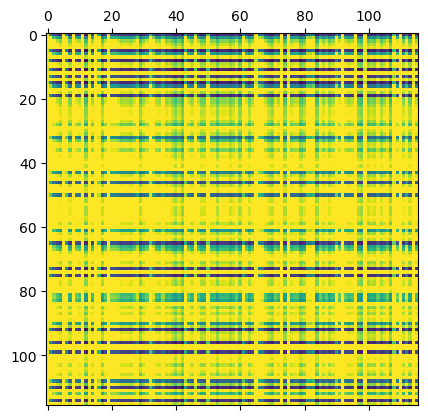

In [100]:
res = getStochOrdersRes(X_learn, y_learn, X, A, w, lamb)
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (res[i] >= res[j]):
            image[i, j] = 1
        else:
            image[i, j] = res[i] / res[j]
        #if (res[i] >= res[j]):
        #    image[i, j] = 1
        #else:
        #    image[i, j] = 0
plt.matshow(image)

plt.show()

Red List

In [112]:
A, w, lamb = learnStochOrders(X[:102],y[:102])

In [118]:
res = getStochOrdersRes(X_learn, y_learn, X_learn, A, w, lamb)
mae_val = np.mean(np.abs(y_learn - res))

res = getStochOrdersRes(X_learn, y_learn, X_test, A, w, lamb)
mae_test = np.mean(np.abs(y_test - res)) 

print('Validation MAE:', mae_val)
print('Test MAE      :', mae_test)

Validation MAE: 1.0929450426061738
Test MAE      : 0.9264904152876686


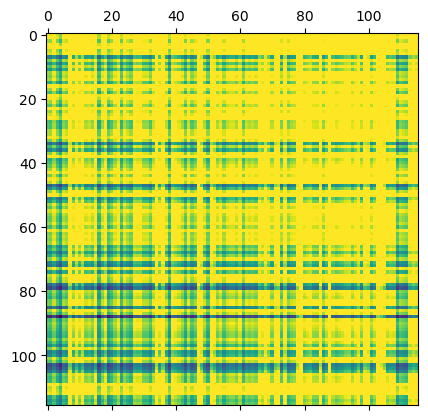

In [120]:
res = getStochOrdersRes(X_learn, y_learn, X, A, w, lamb)
image = np.zeros((len(y), len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        if (res[i] >= res[j]):
            image[i, j] = 1
        else:
            image[i, j] = res[i] / res[j]
        #if (res[i] >= res[j]):
        #    image[i, j] = 1
        #else:
        #    image[i, j] = 0
plt.matshow(image)

plt.show()